# Classification of Sugarcane Diseases based on Images

## Initial Setup

Examining the train data shows that there are six (6) classes in total:

In [2]:
classes = [
    "Banded_Chlorosis",
    "Brown_Rust",
    "Brown_Spot",
    "Viral",
    "Yellow_Leaf",
    "Healthy",
]

classes.sort()
print(classes)

['Banded_Chlorosis', 'Brown_Rust', 'Brown_Spot', 'Healthy', 'Viral', 'Yellow_Leaf']


## Data Loading and Preprocessing



In [ ]:
from pathlib import Path
from pprint import pprint

import keras
import numpy as np
import tensorflow as tf

SEED = 1738  # To make random outcomes reproducible
TRAIN_DIRECTORY = Path("./train")


train_ds: tf.data.Dataset
validation_ds: tf.data.Dataset
ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIRECTORY,
    labels="inferred",
    label_mode="int",  # spare categorical
    class_names=classes,
    color_mode="rgb",
    batch_size=None,  # type: ignore ; to examine the distribution
)


def get_class_distribution(
    dataset, include_class_mappings: bool = False
) -> tuple[dict[int, int], dict[int, str]]:
    class_count = {}
    class_mappings = {}
    class_names = []
    if include_class_mappings:
        class_names = dataset.class_names

    for _, label in dataset:
        label_np = label.numpy()
        if len(class_names) > 0 and class_mappings.get(label_np) is None:
            class_mappings[label_np] = class_names[label_np]
        if class_count.get(label_np) is None:
            class_count[label_np] = 1
            continue
        class_count[label_np] += 1
    return class_count, class_mappings


class_count, class_mappings = get_class_distribution(ds, True)

pprint(class_mappings)

Found 4314 files belonging to 6 classes.
Using 3452 files for training.
Using 862 files for validation.


2025-05-26 20:45:37.971354: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-26 20:45:40.851598: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{np.int32(0): 'Banded_Chlorosis',
 np.int32(1): 'Brown_Rust',
 np.int32(2): 'Brown_Spot',
 np.int32(3): 'Healthy',
 np.int32(4): 'Viral',
 np.int32(5): 'Yellow_Leaf'}


2025-05-26 20:45:41.477197: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Compute class weights
total_images = sum(class_count.values())
weights = {}
for key in class_count:
    weights[key] = total_images / (class_count[key] * len(classes))
pprint(weights)
# print(sum(weights.values()))


# Batch the data set for model compatibility
# Prefetch to optimize
def config_performance(dataset: tf.data.Dataset, batch_size):
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(tf.data.AUTOTUNE)

{np.int32(0): 1.695754716981132,
 np.int32(1): 2.549645390070922,
 np.int32(2): 0.4638709677419355,
 np.int32(3): 1.8578811369509043,
 np.int32(4): 1.204355108877722,
 np.int32(5): 0.6694599627560521}


## Method 1: Convolution Neural Network (CNN)

The first method for solving this classification problem is through the use of CNN.

We will be using the Keras and TensorFlow libraries.

First, let us setup the environment and model.

In [ ]:
import keras
import matplotlib.pyplot as plt
from keras.api import applications
import numpy as np

EPOCHS = 30
DROPOUT_RATE = 0.2
BATCH_SIZE = 128
IMAGE_SIZE = 96

# Repeated here to prepare images with correct IMAGE_SIZE
train_ds: tf.data.Dataset
validation_ds: tf.data.Dataset
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIRECTORY,
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,  # type: ignore
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=True,
    verbose=False,
)

# optimizing training and validation to not take up as much space on our GPU when training our models
# This is even more important when training six different models at once.
train_ds_optimized = config_performance(train_ds, BATCH_SIZE)
validation_ds_optimized = config_performance(validation_ds, BATCH_SIZE)

# A total of 6 models were chosen and tested 
# InceptionResNetV2 performed the best of these and has been chosen as the final model for our model training
models = [
    # applications.InceptionV3,
    # applications.ResNet50V2,
    # applications.ResNet50,
    applications.InceptionResNetV2,
    # applications.MobileNetV3Large,
    # applications.MobileNetV3Small,
]

# Early stop was introduced to stop the training early if the validation loss increased too much
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.001, patience=2, mode="auto", restore_best_weights=True # type: ignore
)

# The following is the training of the model itself. Since only one model is used now,
# As such, only ResNetV2 is being trained and 'model' refers to the ResNetV2 model.
for model in models:
    # We remove the top of the pre-trained model so that we can attach our own at the top later on.
    pre_trained_model = model(
        weights="imagenet",
        classes=len(classes),
        include_top=False,  # The top layer will be replaced with the fully connected layer at the end
    )

    model_label = f"{pre_trained_model.name}-{EPOCHS}"
    print(model_label)

    #This is added to ensure that the pre-trained model's weights remain the same and are not retrained
    for layer in pre_trained_model.layers:
        layer.trainable = False

    transfer_model = keras.models.Sequential(
        [
            # preprocessing layers
            keras.layers.Rescaling(1.0 / 255),
            # data augmentation layers
            # keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
            # keras.layers.RandomBrightness(factor=0.2, seed=SEED),
            # keras.layers.RandomContrast(factor=0.1, seed=SEED),
            pre_trained_model,
            # fully connected
            # keras.layers.Flatten(),
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dense(1024, activation="relu"),
            keras.layers.Dropout(DROPOUT_RATE),
            keras.layers.Dense(1024, activation="relu"),
            keras.layers.Dropout(DROPOUT_RATE),
            keras.layers.Dense(len(classes), activation="softmax"),
        ]
    )

    # transfer_model.summary()
    transfer_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # type: ignore
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="Accuracy"),
        ],
    )

    history = transfer_model.fit(
        train_ds_optimized,
        epochs=EPOCHS,
        validation_data=validation_ds_optimized,
        class_weight=weights,
        callbacks=[early_stop],
    )
    
    # The final weights are then saved depending on the model's name. 
    # In our case, the results of ResNet V2 are saved.
    transfer_model.save(f"./results/models/{model_label}.keras")

Using 3452 files for training.
Using 862 files for validation.
inception_resnet_v2-30
Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - Accuracy: 0.3873 - loss: 1.8966 - val_Accuracy: 0.6845 - val_loss: 0.8703
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - Accuracy: 0.7439 - loss: 0.6744 - val_Accuracy: 0.7981 - val_loss: 0.5354
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - Accuracy: 0.8317 - loss: 0.4388 - val_Accuracy: 0.8492 - val_loss: 0.4061
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - Accuracy: 0.8788 - loss: 0.3171 - val_Accuracy: 0.8538 - val_loss: 0.4276
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - Accuracy: 0.9041 - loss: 0.2631 - val_Accuracy: 0.8643 - val_loss: 0.3808
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - Accuracy: 0.9131 - loss: 0.2261 - val_Accuracy: 0.9118 - val_loss: 0.2718
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - Accuracy: 0.9277 - loss: 0.1921 - val_Accuracy: 0.9002 - val_loss: 0.2876
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━

### Method 1: Model Results

Now that we have trained the model, it's time to test how well the model actually did.

There are a few ways we can do this. One of which is looking at the models precision, recall, and f1-scores, while another way is by looking at the resulting confusion matrix. We implement both of these methods to get a better idea of how well our model actually performed.

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step 
                  precision    recall  f1-score   support

Banded_Chlorosis       0.79      0.79      0.79        82
      Brown_Rust       0.72      0.98      0.83        54
      Brown_Spot       1.00      0.94      0.97       314
         Healthy       0.96      0.95      0.95        75
           Viral       0.91      0.88      0.90       126
     Yellow_Leaf       0.95      0.96      0.96       211

        accuracy                           0.93       862
       macro avg       0.89      0.92      0.90       862
    weighted avg       0.93      0.93      0.93       862



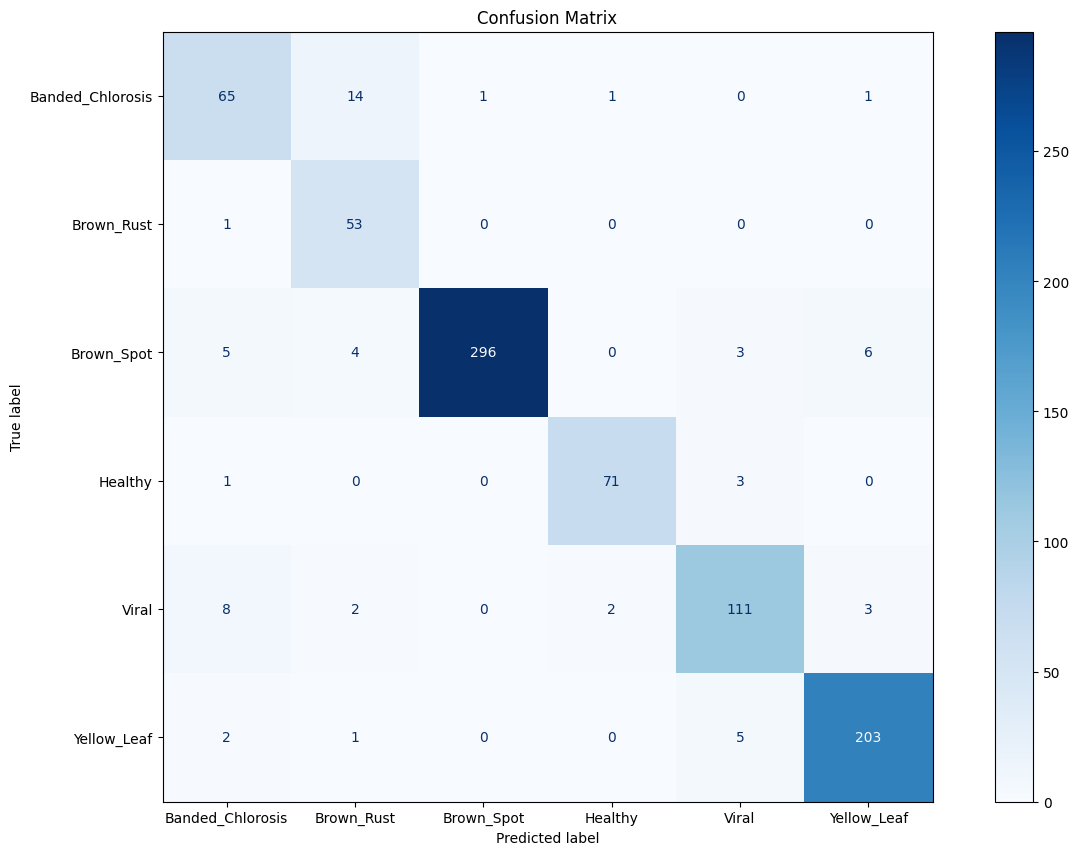

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# This is to get the predictions of the transfer model based on the data for validation
y_pred = transfer_model.predict(validation_ds_optimized)
y_pred_classes = np.argmax(y_pred, axis=1)  # get index of highest probability to convert probabilities to class indices

y_true = np.concatenate([y for _, y in validation_ds_optimized], axis=-1)  # type: ignore ; get labels

#This gives the report of the model and its precision, recall, and f1 score for each class
report = classification_report(y_true, y_pred_classes, target_names=classes)
print(report)

#This gives the confusion matrix of the model and shows how well (or not) the model predicted the validation images
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(16, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())  # type: ignore
plt.title("Confusion Matrix")
plt.show()

### Method 1: Model Plots

For an overview of how our model performed over the course of its training, we can create plots to see the trend in the model's accuracy and losses. 


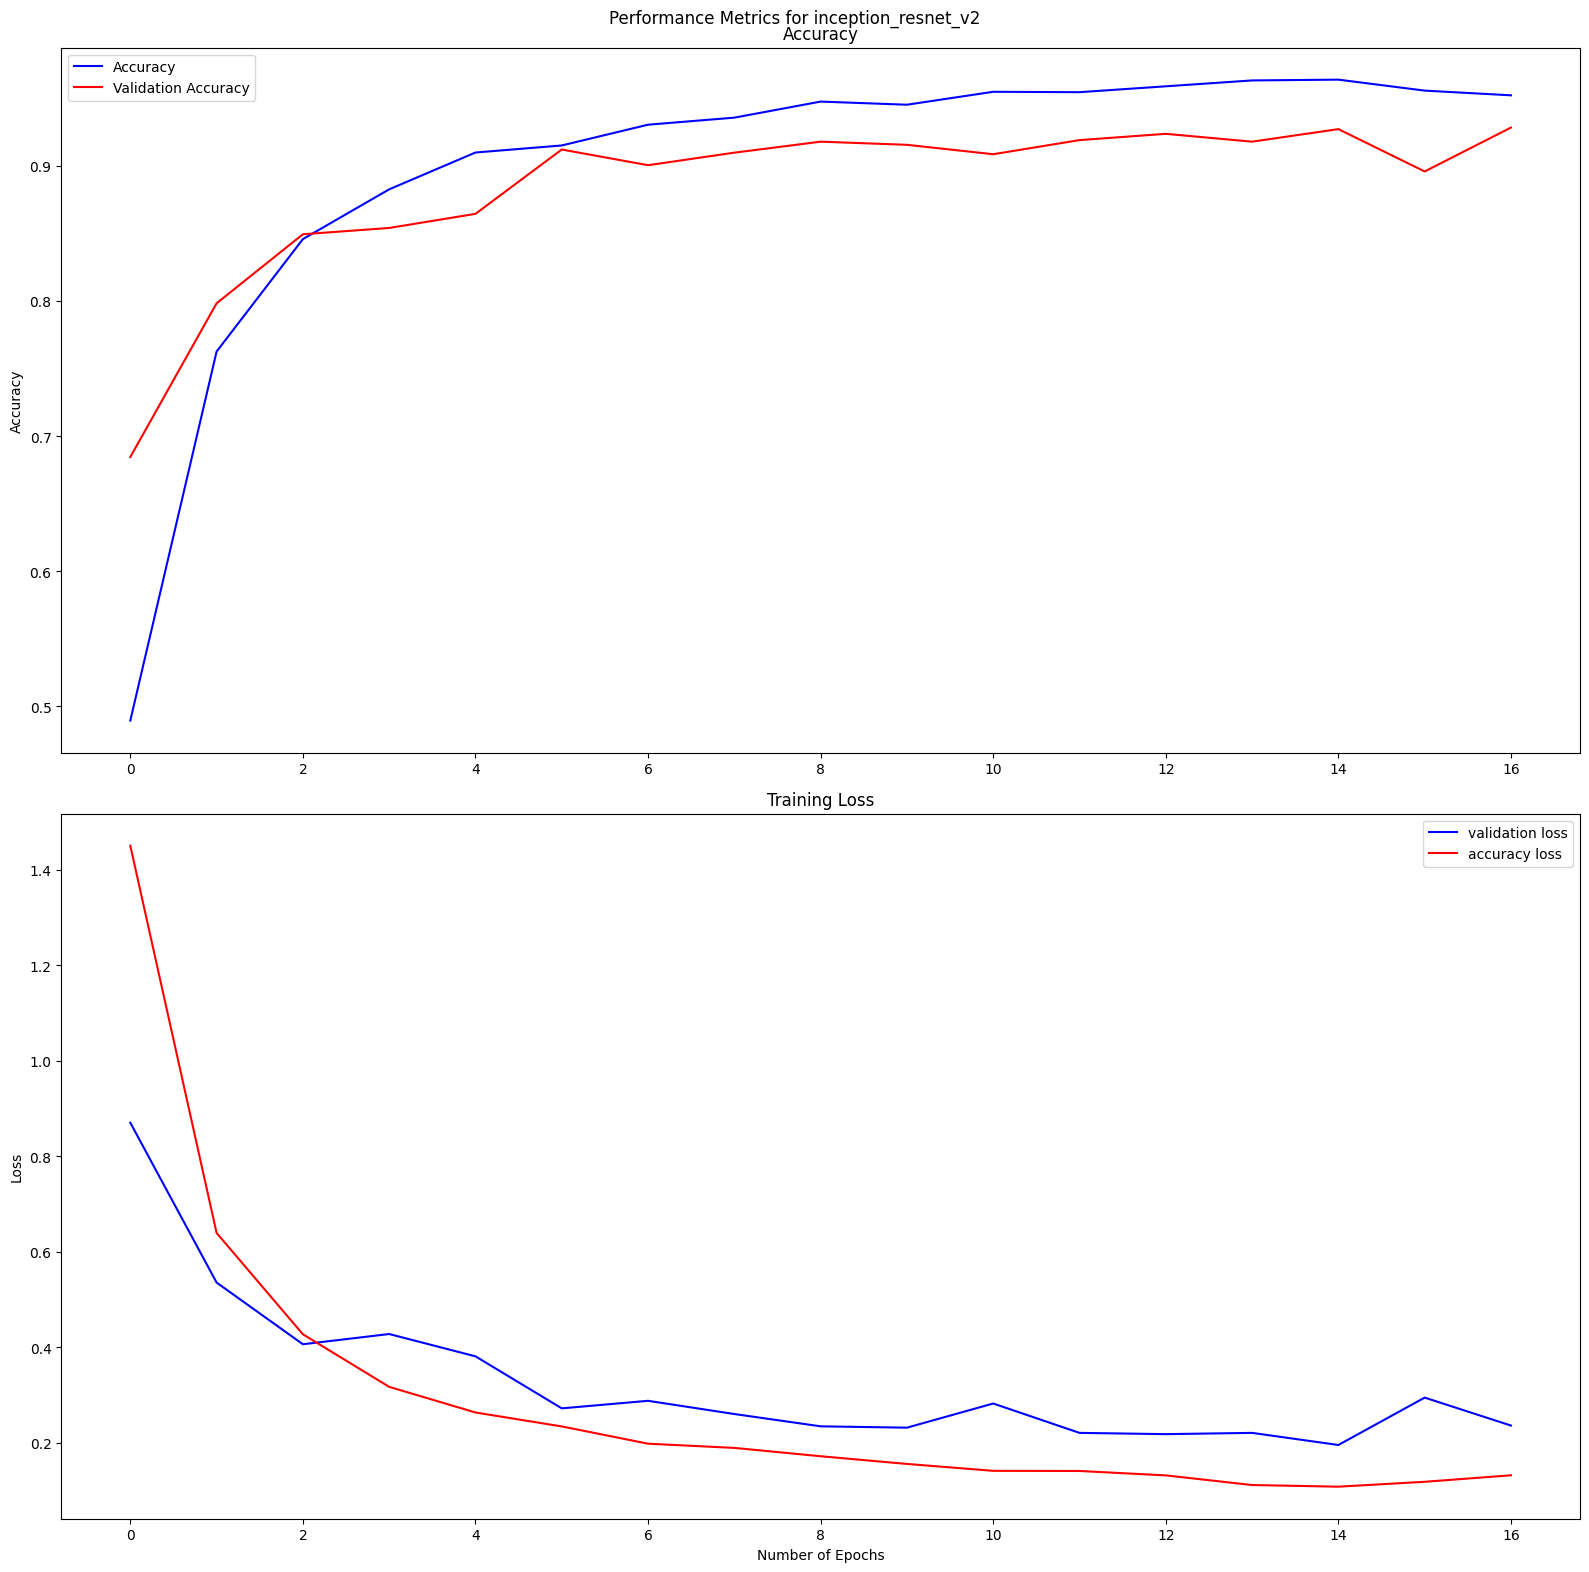

In [ ]:
def generate_metric_plots(history):
    fig, axs = plt.subplots(2)
    fig.set_size_inches(w=16, h=16)
    fig.set_layout_engine("tight")
    fig.suptitle(f"Performance Metrics for {pre_trained_model.name}")
    # Show the accuracy and validation accuracy
    axs[0].plot(history.history["Accuracy"], color="b", label="Accuracy")
    axs[0].plot(history.history["val_Accuracy"], color="r", label="Validation Accuracy")
    axs[0].set_title("Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # show the training (and validation) loss
    axs[1].plot(history.history["val_loss"], color="b", label="validation loss")
    axs[1].plot(history.history["loss"], color="r", label="accuracy loss")
    axs[1].set_title("Training Loss")
    axs[1].set_xlabel("Number of Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    plt.show()
    fig.savefig(f"./results/graph/{model_label}.png")


generate_metric_plots(history)

### Method 1: Model Summary

To see the parameters and its distribution across layers, we can use summary() on our model

In [ ]:
transfer_model.summary()  # either remove or move

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 1, 1, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1024)           │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,225,652 (237.37 MB)

 Trainable params: 2,629,638 (10.03 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

 Optimizer params: 5,259,278 (20.06 MB)

## Method 2: Vision Transformer

In [ ]:
import keras_hub

EPOCHS = 3
DROPOUT_RATE = 0.2
BATCH_SIZE = 32
IMAGE_SIZE = 64
PRESET = "vit_base_patch16_224_imagenet21k"

# Repeated here to prepare images with correct IMAGE_SIZE
train_ds: tf.data.Dataset
validation_ds: tf.data.Dataset
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIRECTORY,
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,  # type: ignore
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=True,
    verbose=False,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.001, patience=2, mode="auto", restore_best_weights=True # type: ignore
)

train_ds_optimized = config_performance(train_ds, BATCH_SIZE)
validation_ds_optimized = config_performance(validation_ds, BATCH_SIZE)

vit_backbone = keras_hub.models.Backbone.from_preset(PRESET, load_weights=True)

vit_backbone.layers[-1].trainable = False  # freeze encoder layer

vit_backbone.summary()

transfer_model = keras.models.Sequential(
    [
        # preprocessing layers
        keras_hub.layers.ViTImageConverter.from_preset(PRESET),
        # data augmentation layers
        # keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
        # keras.layers.RandomBrightness(factor=0.2, seed=SEED),
        # keras.layers.RandomContrast(factor=0.1, seed=SEED),
        vit_backbone,
        # fully connected
        # keras.layers.Flatten(),
        keras.layers.GlobalAveragePooling1D(),
        # keras.layers.Dense(1024, activation="relu"),
        # keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Dense(len(classes), activation="softmax"),
    ]
)

# transfer_model.summary()

transfer_model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # type: ignore
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="Accuracy"),
        keras.metrics.Precision(name="Precision"),
        keras.metrics.Recall(name="Recall"),
    ],
)  # type: ignore
transfer_model.summary()

history = transfer_model.fit(
    train_ds_optimized,
    epochs=EPOCHS,
    validation_data=validation_ds_optimized,
    class_weight=weights,
    callbacks=[early_stop],
)

Using 3452 files for training.
Using 862 files for validation.


Model: "vi_t_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vit_patching_and_embedding      │ (None, 197, 768)       │       742,656 │
│ (ViTPatchingAndEmbedding)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vit_encoder (ViTEncoder)        │ (None, 197, 768)       │    85,056,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,798,656 (327.30 MB)

 Trainable params: 742,656 (2.83 MB)

 Non-trainable params: 85,056,000 (324.46 MB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vi_t_image_converter            │ ?                      │   0 (unbuilt) │
│ (ViTImageConverter)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_backbone (ViTBackbone)     │ (None, 197, 768)       │    85,798,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,798,656 (327.30 MB)

 Trainable params: 742,656 (2.83 MB)

 Non-trainable params: 85,056,000 (324.46 MB)

Epoch 1/3


/home/ubuntu/CS180-Project/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:1410: UserWarning: Layer 'vi_t_image_converter' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''ViTImageConverter.call() missing 1 required positional argument: 'x'''
  warnings.warn(
/home/ubuntu/CS180-Project/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'vi_t_image_converter', however the layer does not have

  2/108 ━━━━━━━━━━━━━━━━━━━━ 37:47 21s/step - Accuracy: 0.2109 - TopK: 0.5938 - loss: 1.9697

KeyboardInterrupt: 